In [152]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.direct_model import DirectModel
from sasdata.dataloader.loader import Loader
from sasmodels import weights
from sasmodels.data import empty_data1D

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps import parameter

import glob
import uuid
import re

from saxs_data_processing import io

from sklearn import metrics
import pandas
import os


## Set up scattering model

working in angstroms for q and particle diameters


In [11]:
sld_silica = 8.575
sld_etoh = 9.611

q_min = -2
q_max = 0
n_q = 501

# r in nm
r_min = 20
r_max = 500
n_r = 501

target_r = 600 #(120 nm diameter particles)
target_pdi = 0.1
delta_sld = np.abs(sld_silica - sld_etoh)





## sasmodels sphere as target I

In [12]:
def target_intensities(q, r, pdi):
    """
    Calculate target scattering intensity for a given q array, radius (angstroms), and pdi
    """
    kernel = load_model('sphere')
    data = empty_data1D(q)
    pars = dict(scale = 1, background = 0.001, sld = sld_silica, sld_solvent = sld_etoh, radius = 50)
    model = DirectModel(data, kernel)
    #model.radius.range(10, 5000)
    #model.scale.range(0, 5)
    
    I = model(radius = 40, radius_pd = 0.1, radius_pd_type = 'gaussian', radius_pd_n = 35, radius_pd_nsigma = 3)

    return I

In [13]:
## Load subtracted data

In [14]:
def load_data_files(root_dirs, bio_conf):
    """
    Finds all .dat files, returns those with bio configuration equal to bio_conf

    Non-recursively checks all root directories for .dat files, parses them, if biocube conf is correct, returns 


    Returns: dict(sample_uuid:brenden data tuple)
    """

    # 1. Find all the filepaths in root directories of .dat files
    fps_agg = []
    for root_dir in root_dirs:
        fps = glob.glob('**.dat', root_dir=root_dir, recursive=False)
        fps_agg.extend([root_dir + fp for fp in fps])


    # 2. process filepaths, get uuids for those that are sample data (as opposed to backgrounds). load those that match target config
    data_fps = {}
    sample_data = {}
    not_data_count = 0
    not_esaxs_count = 0
    for fp in fps_agg:
        uuid_str = fp.split('/')[-1].split('.')[0]
        #print(uuid_str)
        data_val = io.read_1D_data(fp)
        sample_data[uuid_str] = data_val
                

    return sample_data
        

In [15]:
def is_valid_uuid(uuid_to_test, version=4):
    try:
        # check for validity of Uuid
        uuid_obj = uuid.UUID(uuid_to_test, version=version)
    except ValueError:
        return False
    return True

In [99]:
data = load_data_files(['./test_1d/'], bio_conf=24)

In [17]:
test_uuid = '01cddefc-e6a6-41aa-9052-06286b12b8fe'
test_data = data[test_uuid][0]

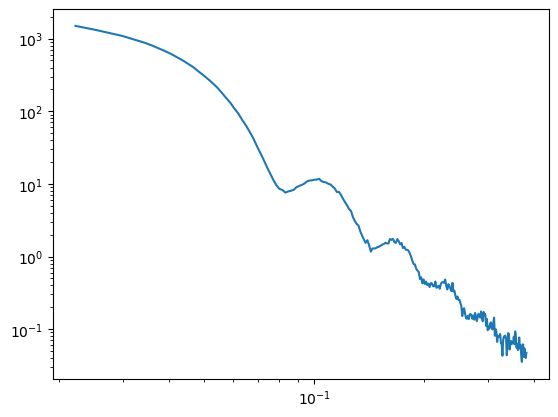

In [18]:
plt.loglog(test_data['q'], test_data['I'])

In [90]:
rmse_log_vals = {}
for uuid_val, data_val in data.items():
   # print('starting ', uuid_val)
    data_val = data_val[0]
    q = data_val['q'].to_numpy()
    target_I = target_intensities(q, target_r, target_pdi)

    

    target_I = target_I/target_I[0]
    meas_I = data_val['I']/data_val['I'].iloc[0]

    # drop negative values
    drop_ind = meas_I[meas_I<0].index
    meas_I = meas_I.drop(drop_ind)
    target_I = np.delete(target_I, drop_ind)
    
    rmse = metrics.root_mean_squared_error(target_I, meas_I)
    rmse_log = metrics.root_mean_squared_error(np.log10(target_I), np.log10(meas_I))
    r2 = metrics.r2_score(target_I, meas_I)

    rmse_log_vals[uuid_val] = rmse_log
    #fig, ax = plt.subplots()

    #ax.loglog(q, target_I)
    #ax.loglog(q, meas_I)
    #ax.text(0.1, 0.1, f'RMSE: {rmse}\nRMSE_log: {rmse_log}\nR2: {r2}')
    #ax.set_title(uuid_val)

/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [80]:
# sort resulting metric values

uuids = np.array(list(rmse_log_vals.keys()))
rmses = list(rmse_log_vals.values())

In [81]:
uuid_sorted = uuids[np.argsort(rmses)]

In [ ]:
for uuid_val in uuid_sorted:
    data_val = data[uuid_val][0]
    q = data_val['q'].to_numpy()
    target_I = target_intensities(q, target_r, target_pdi)

    

    target_I = target_I/target_I[0]
    meas_I = data_val['I']/data_val['I'].iloc[0]

    
    rmse_log = rmse_log_vals[uuid_val]
    fig, ax = plt.subplots()

    ax.loglog(q, target_I)
    ax.loglog(q, meas_I)
    ax.text(0.1, 0.1, f'RMSE_log: {rmse_log}')
    ax.set_title(uuid_val)
    

In [88]:
## Screen data on power law fit

In [89]:
def fit_power_law(data, ax = None):
    kernel = load_model('power_law')

    pars = dict(scale = 1, background = 0.001, power = 4.0)
    model = Model(kernel, **pars)
    model.power.range(0, 10)
    model.scale.range(0, 5)
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)

    result = fit(problem, method='amoeba')
    
    results = {}
    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv
    results['chisq'] = problem.chisq_str()


    return results, result, problem

In [92]:
def df2data(df):
    fp = 'temp.dat'
    io.write_dat(df, {'metadata':None}, fp)
    loader = Loader()
    data = loader.load(fp)
    os.remove(fp)
    return data[0]

In [131]:
cutoff_chisq = 200

In [147]:
distance_results = {}
for uuid_val, data_val_df in data.items():
    try:
        #print(uuid_val)
        # Run power law fit to figure out if we run a distance metric on this
        data_val = df2data(data_val_df[0])
        data_val.qmin = data_val.x.min()
        data_val.qmax = data_val.x.max()
        data_val.mask = np.isnan(data_val.y)
        power_results = fit_power_law(data_val)
        results[uuid_val] = power_results
    
        if float(power_results[0]['chisq'].split('(')[0]) < cutoff_chisq:
            distance_results[uuid_val] = 50
        else:
            # calculate rmse distance to target 
            q = data_val_df[0]['q'].to_numpy()
            target_I = target_intensities(q, target_r, target_pdi)
        
            
        
            target_I = target_I/target_I[0]
            meas_I = data_val_df[0]['I']/data_val_df[0]['I'].iloc[0]
        
            # drop negative values
            drop_ind = meas_I[meas_I<0].index
            meas_I = meas_I.drop(drop_ind)
            target_I = np.delete(target_I, drop_ind)
            
            rmse = metrics.root_mean_squared_error(target_I, meas_I)
            rmse_log = metrics.root_mean_squared_error(np.log10(target_I), np.log10(meas_I))
    
            distance_results[uuid_val] = rmse_log
    except:
        continue
            
    
   

In [148]:
distance_results

{'b59dad1a-4440-453a-b36a-9efd6e49a282': 50,
 'fe8e4a28-cb6b-4396-adc3-a51f49838d54': 1.8091721480623266,
 'a6974af8-5b2d-431a-94df-d35c0be3ee54': 50,
 '403cbac3-a2e0-44f0-aca4-9313b8775a4e': 50,
 '5edc0763-1f2c-44f2-bf68-db785ae258b0': 50,
 '50d45172-6479-4d31-9ef6-bea791278606': 1.1737002127858247,
 'a9d67fc5-2e59-4f51-a904-9cac957c9e73': 0.4580984311685377,
 'c2755e87-75e2-48c6-b27a-739971d1775c': 50,
 '1c809d50-4605-4865-aa13-13649203ede8': 50,
 'a3f7d49b-cc77-4468-aae0-ad451027ddc0': 50,
 '852b1fcf-ea63-4436-bd20-9ebf44baf999': 0.3934710846503651,
 '3b660550-7e2e-4815-ba89-ac39039b2f38': 50,
 '01cddefc-e6a6-41aa-9052-06286b12b8fe': 0.5213722186071564,
 '83d8158b-ea97-4925-af7c-8fa89acc9319': 1.3256434144779146,
 'f4b66637-2c73-4d0b-83ba-3f7e3b3f3c06': 1.3587937862152795,
 'decddea8-7eee-4ca3-9344-5b6f201057b3': 50,
 '6abcfcc8-cf8d-4a5e-a92f-f3afd8023fbd': 50,
 'ba91b97c-6a58-431f-99ae-091ae1a16bc8': 50,
 '2811e6fa-3ff3-42bc-a3cf-bcc61a8cf0fd': 50,
 '3ae01d8c-6757-4aa4-8701-a4f231f

In [150]:
uuids = np.array(list(distance_results.keys()))
rmses = list(distance_results.values())
uuid_sorted = uuids[np.argsort(rmses)]

/tmp/ipykernel_98731/69394288.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


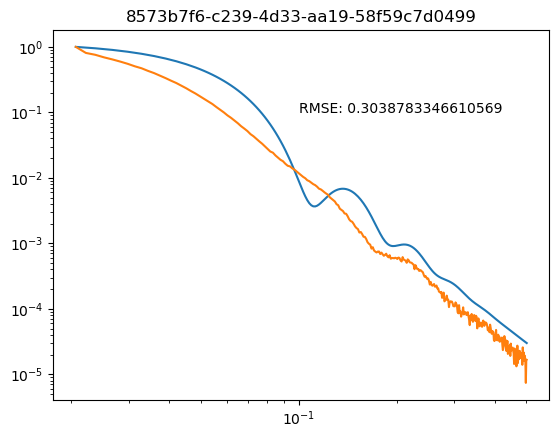

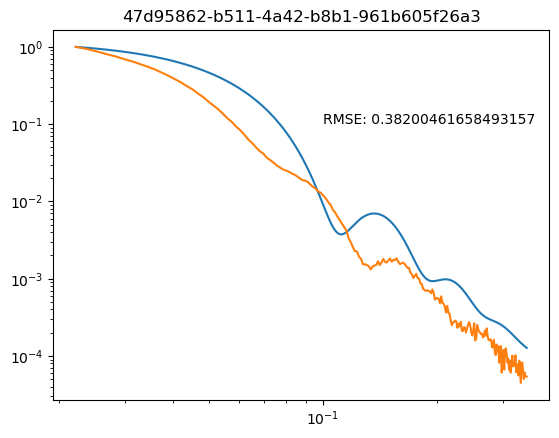

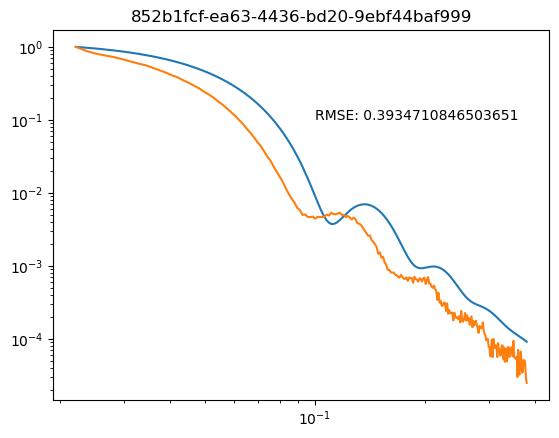

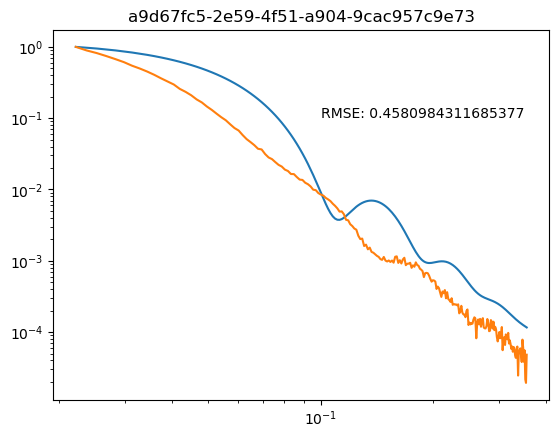

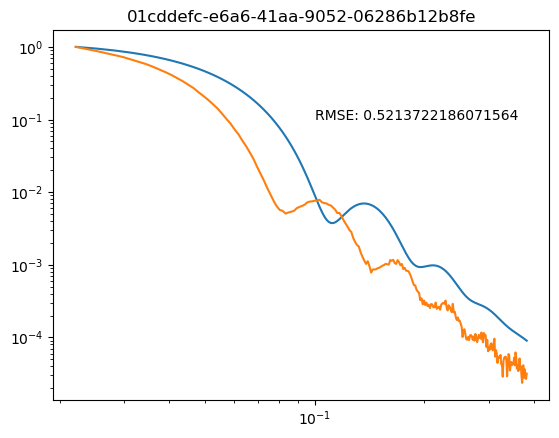

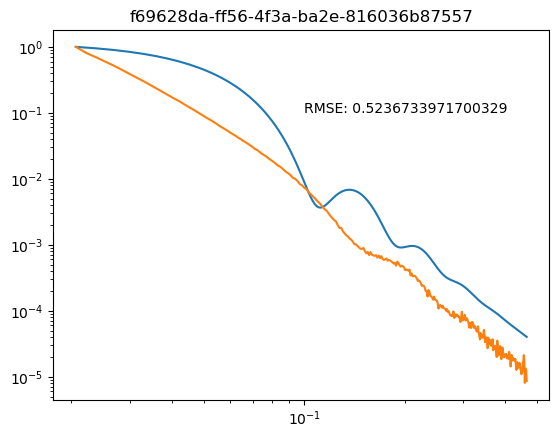

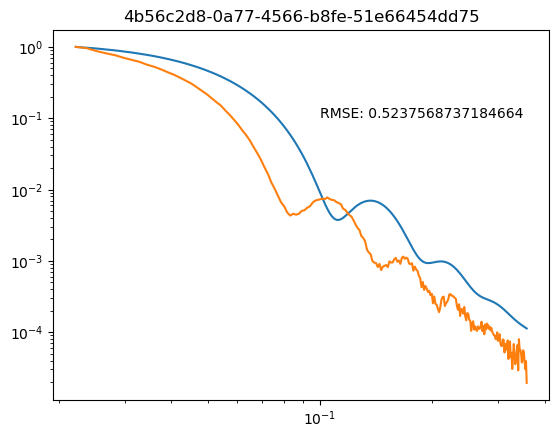

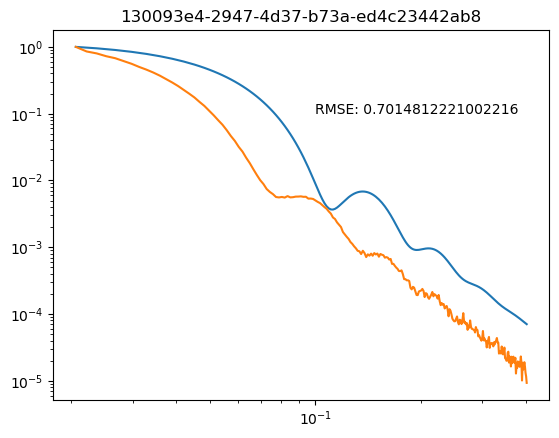

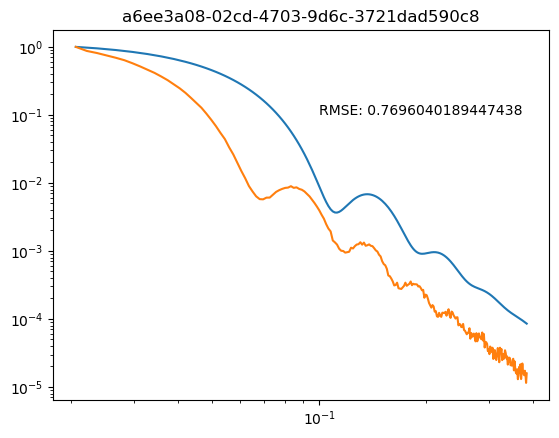

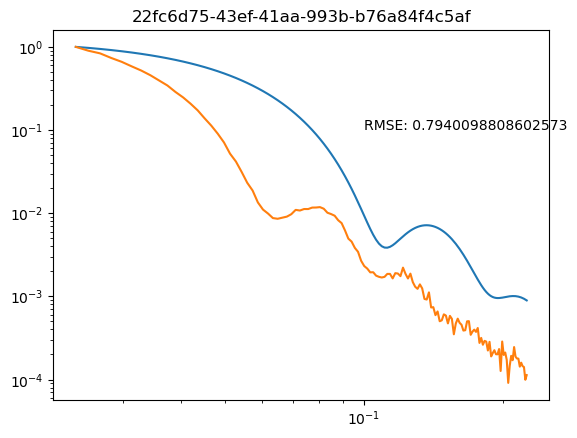

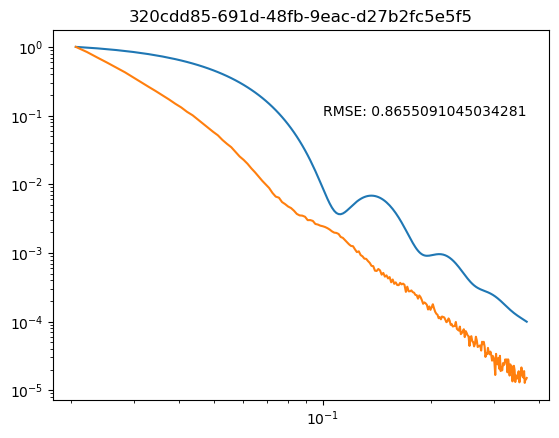

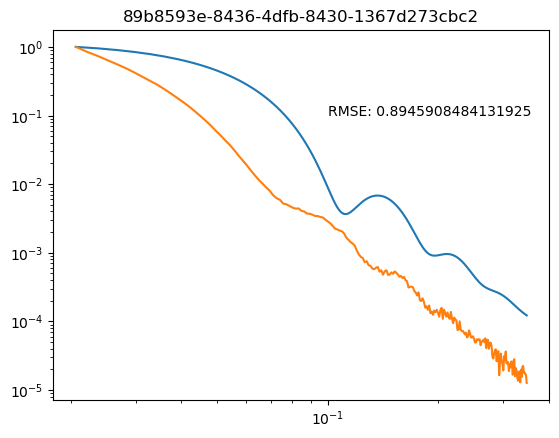

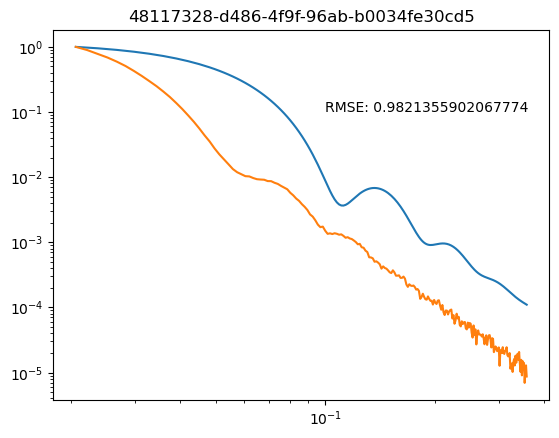

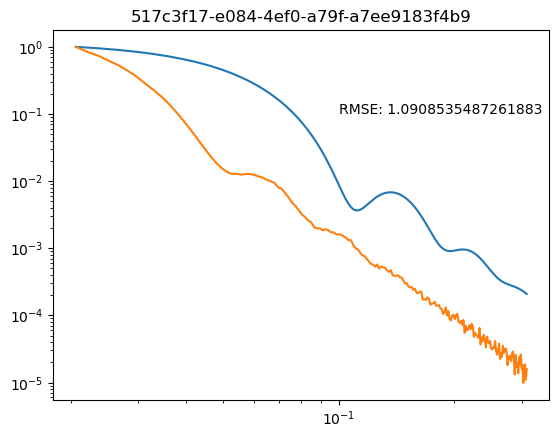

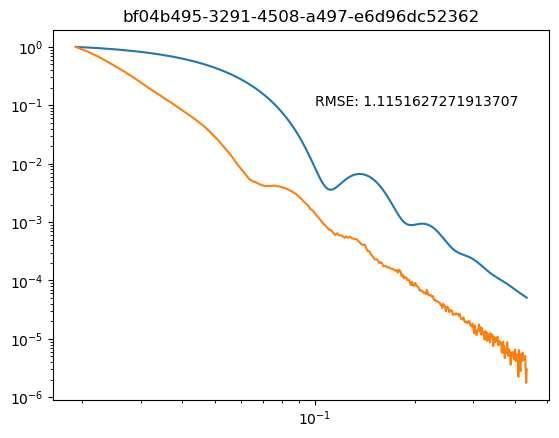

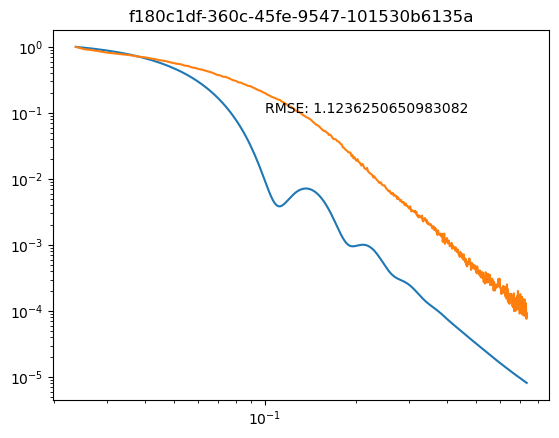

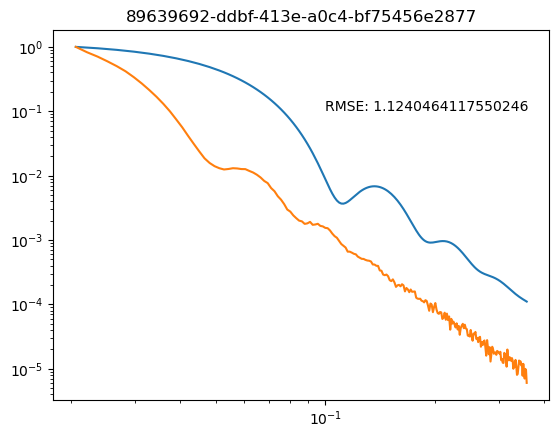

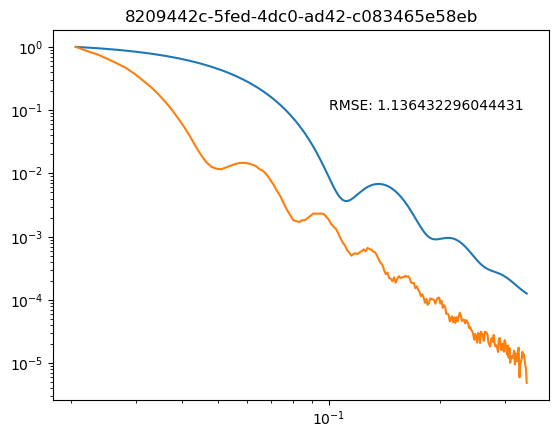

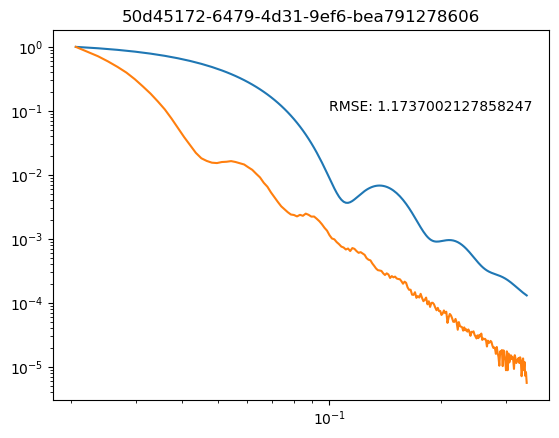

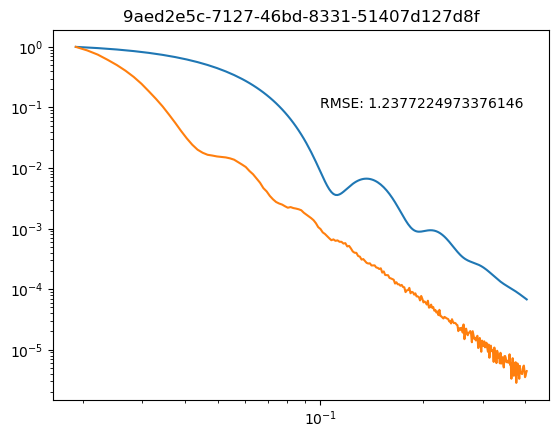

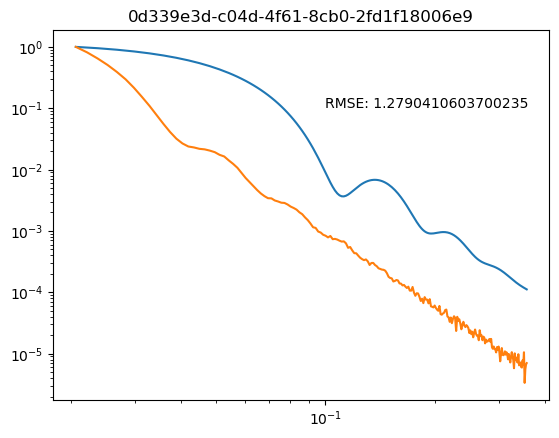

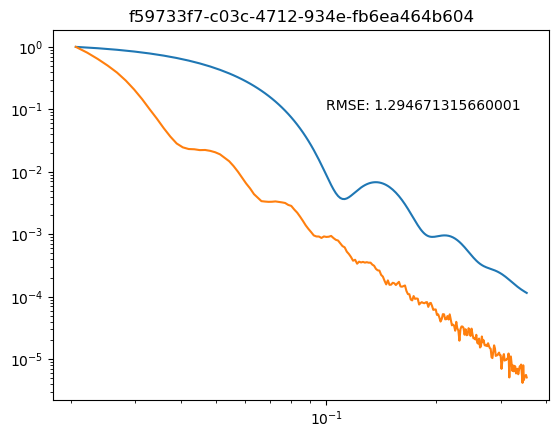

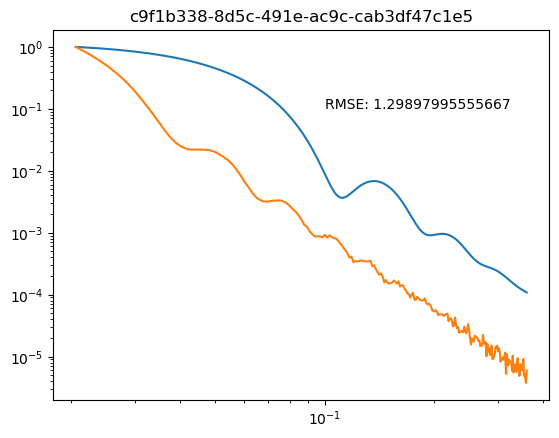

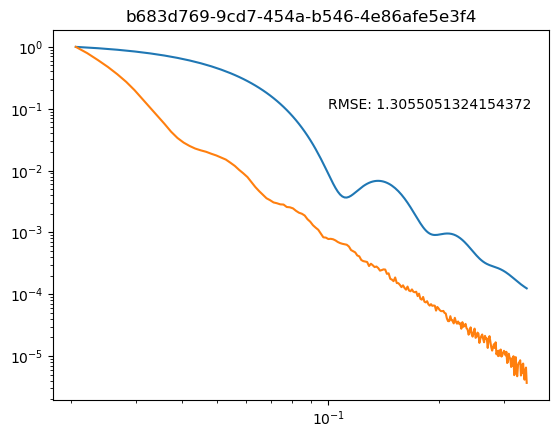

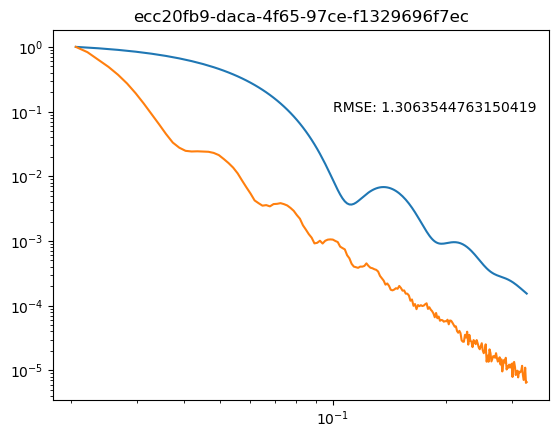

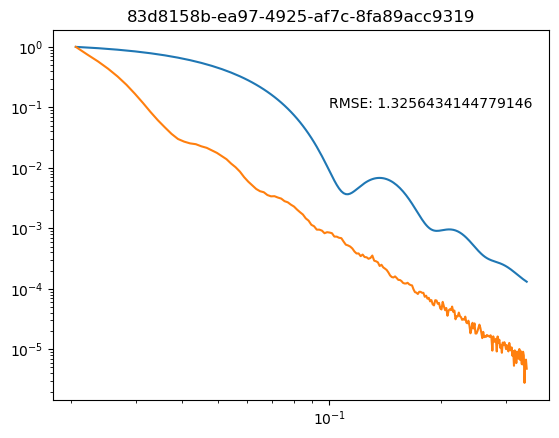

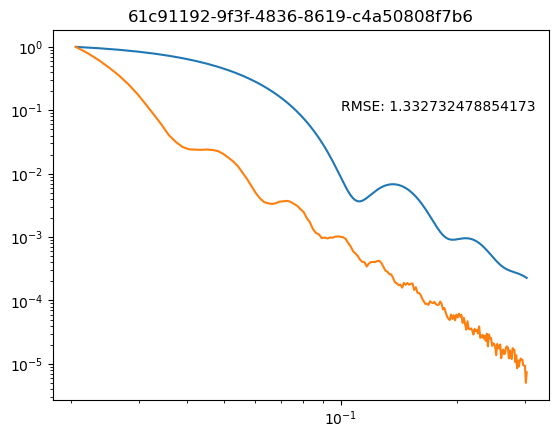

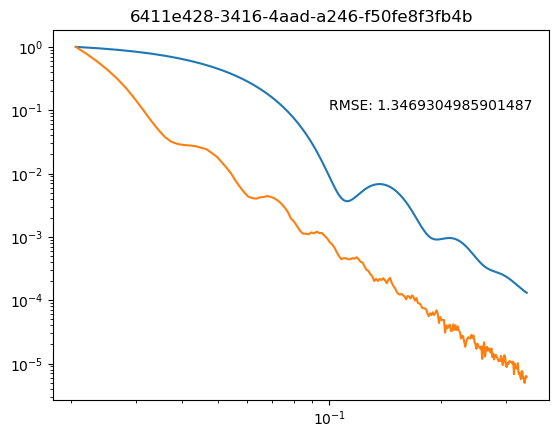

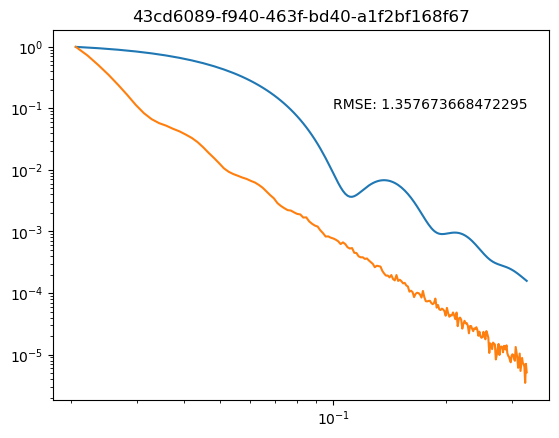

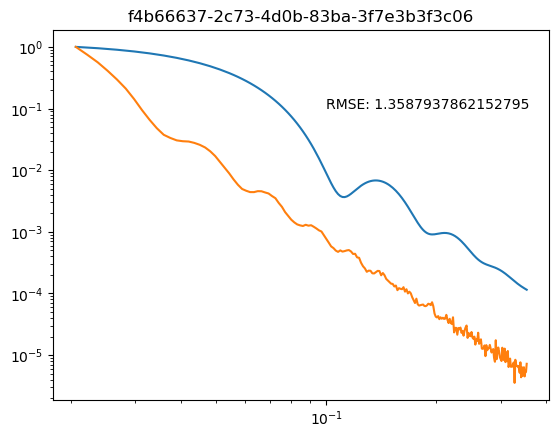

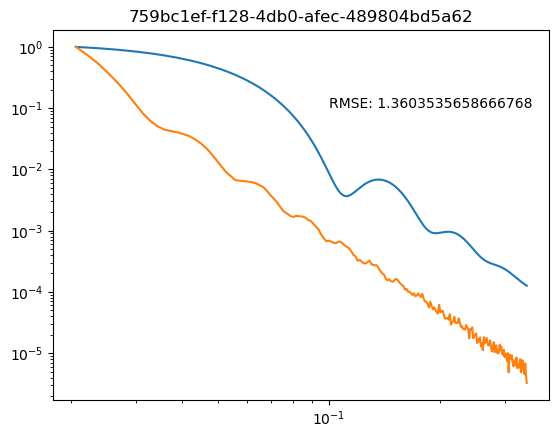

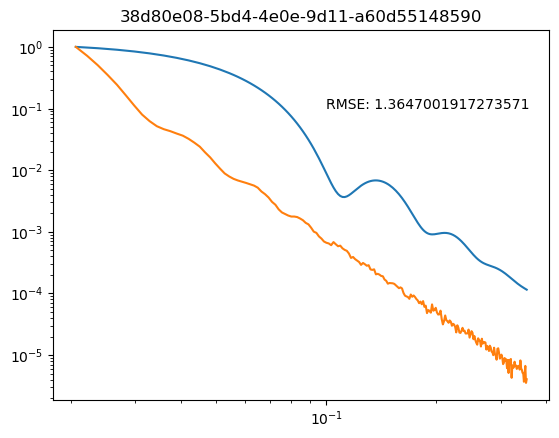

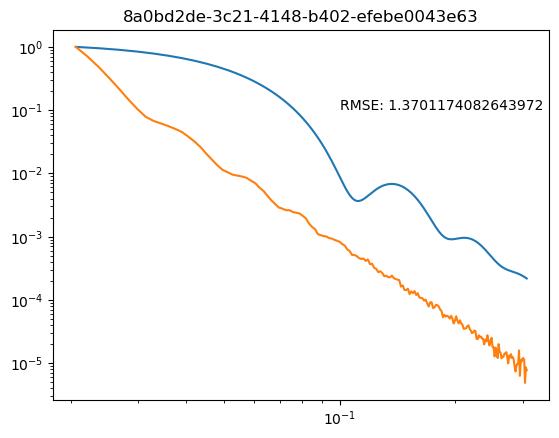

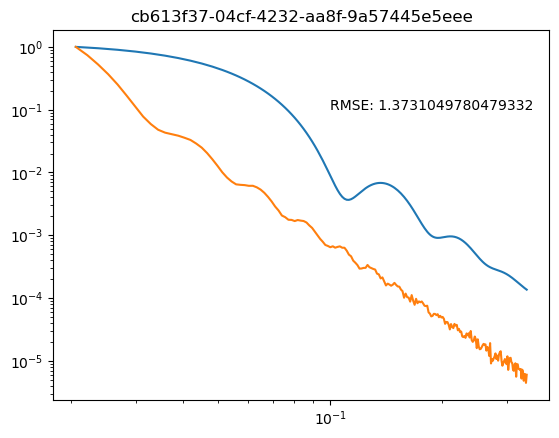

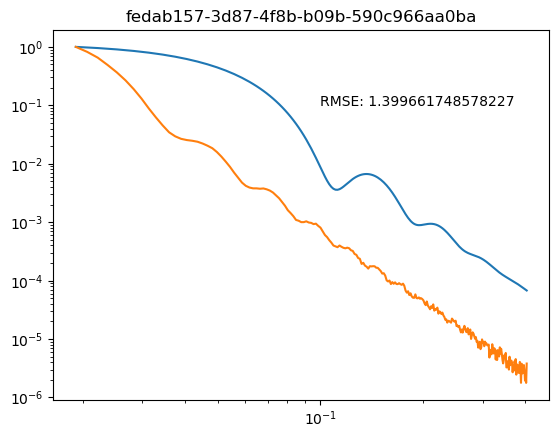

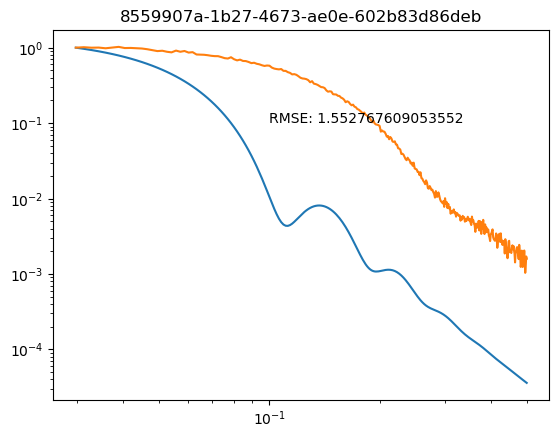

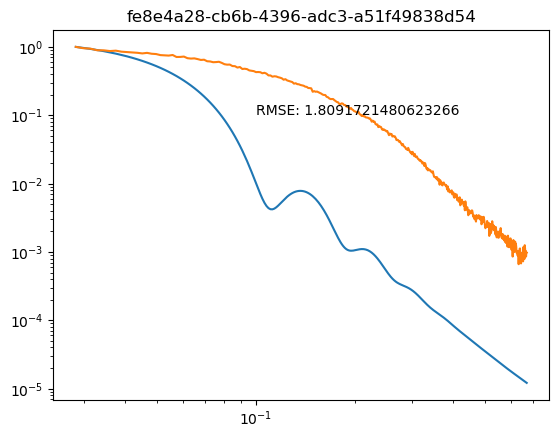

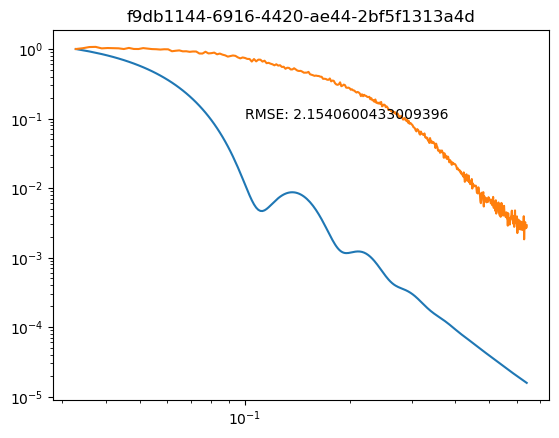

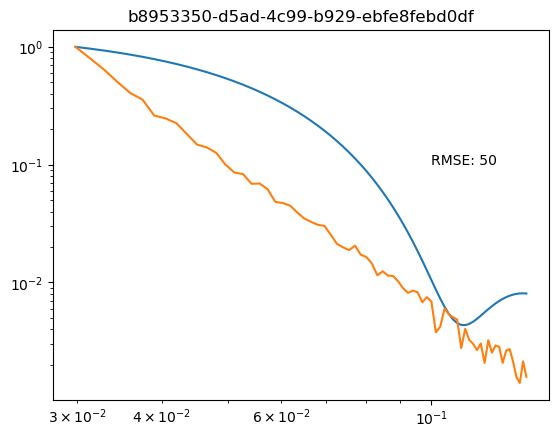

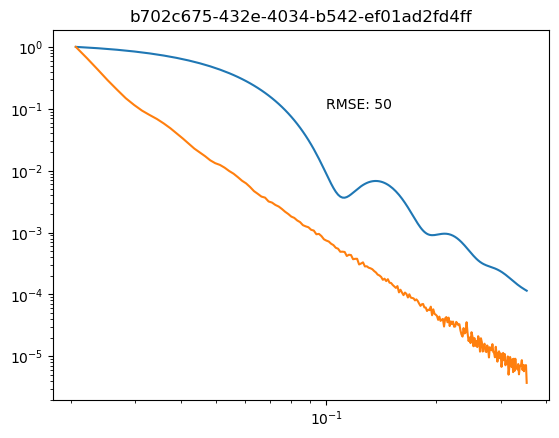

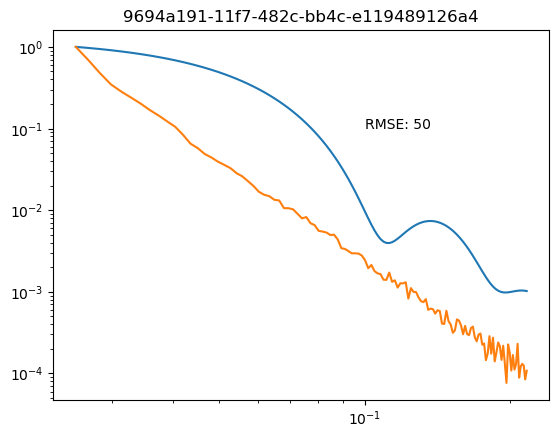

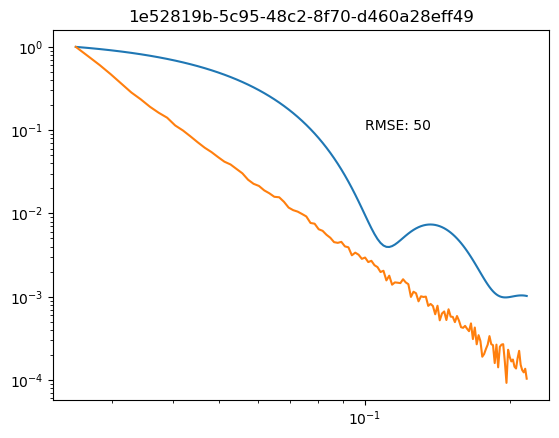

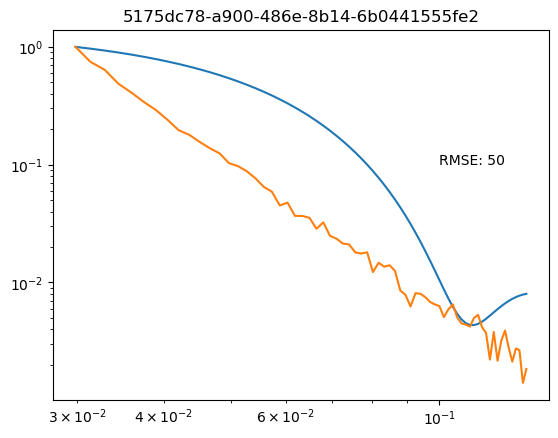

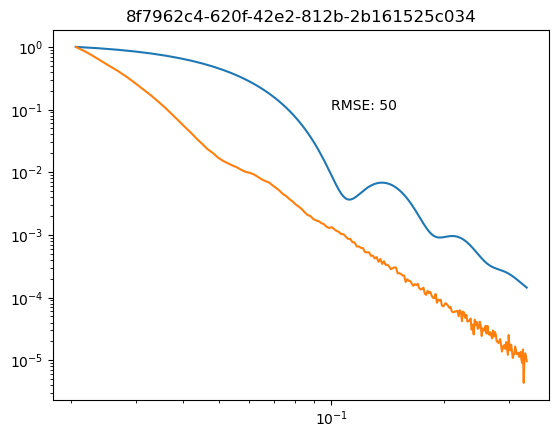

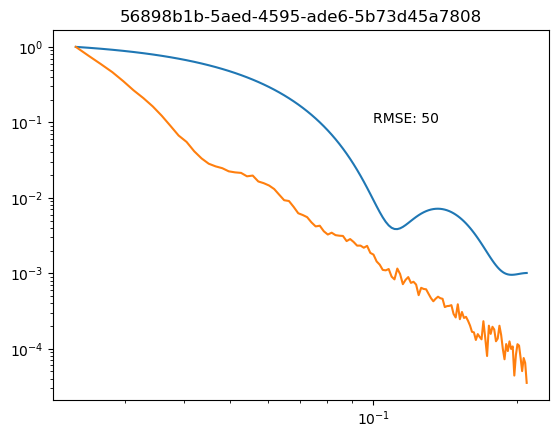

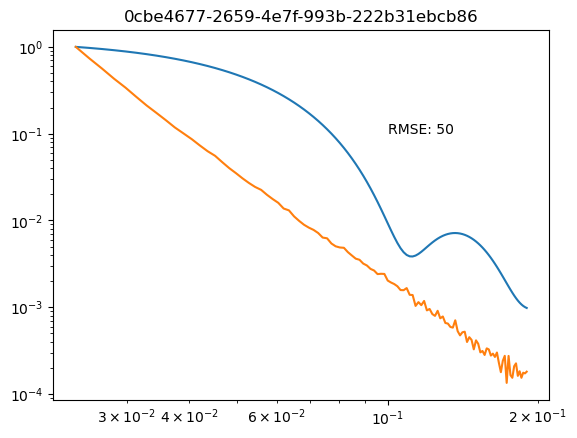

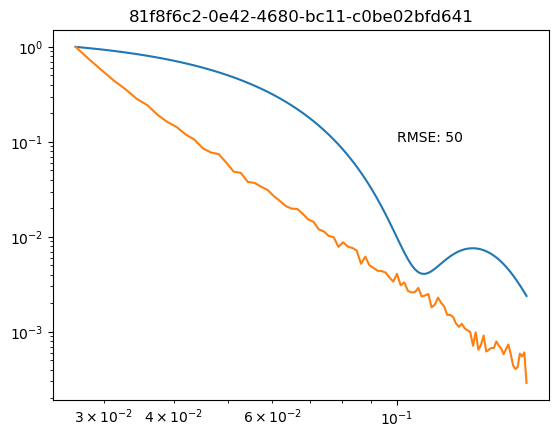

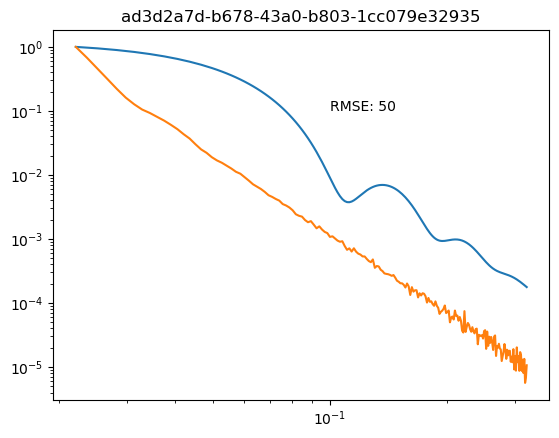

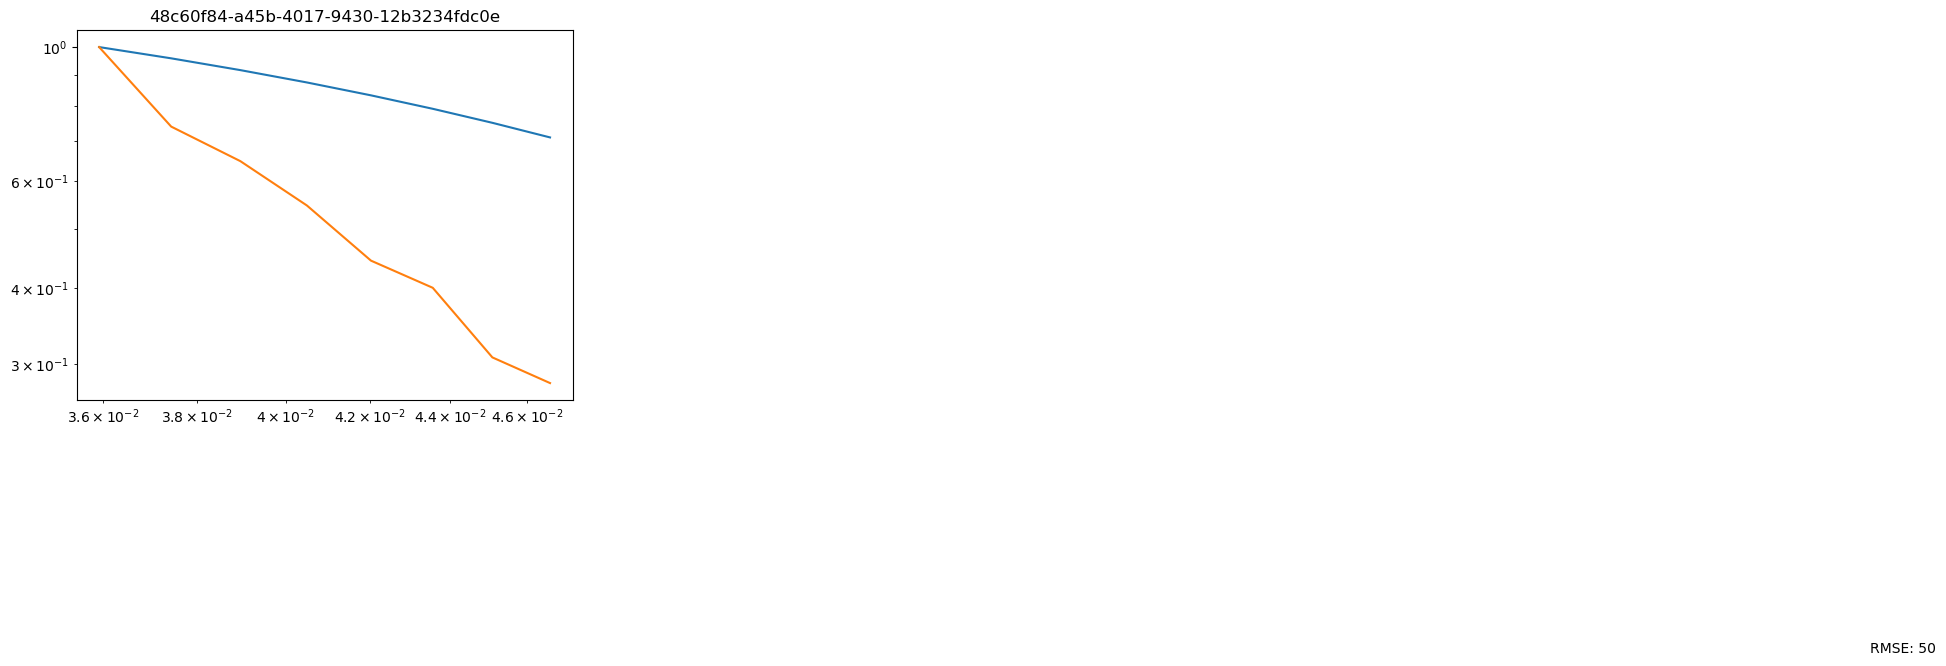

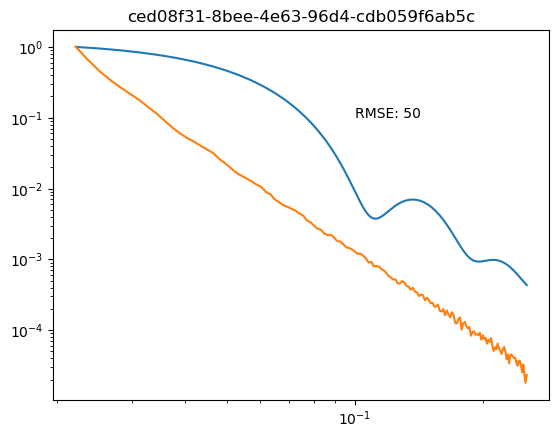

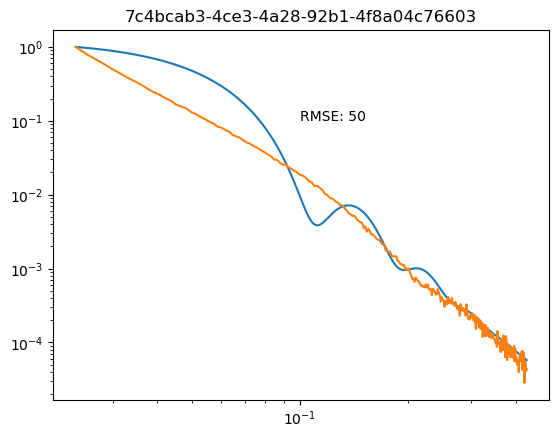

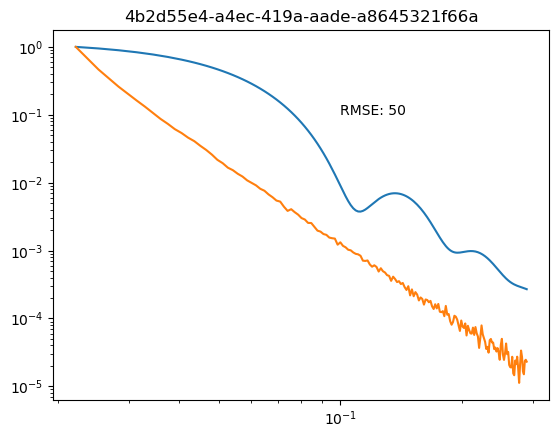

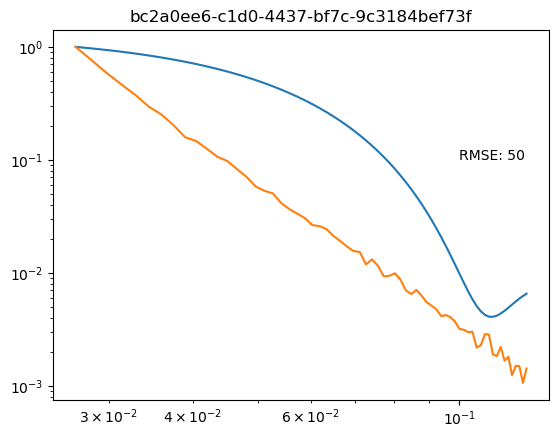

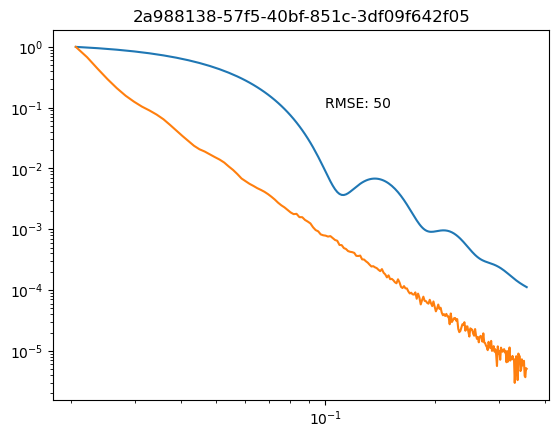

ValueError: Image size of 82041x665 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

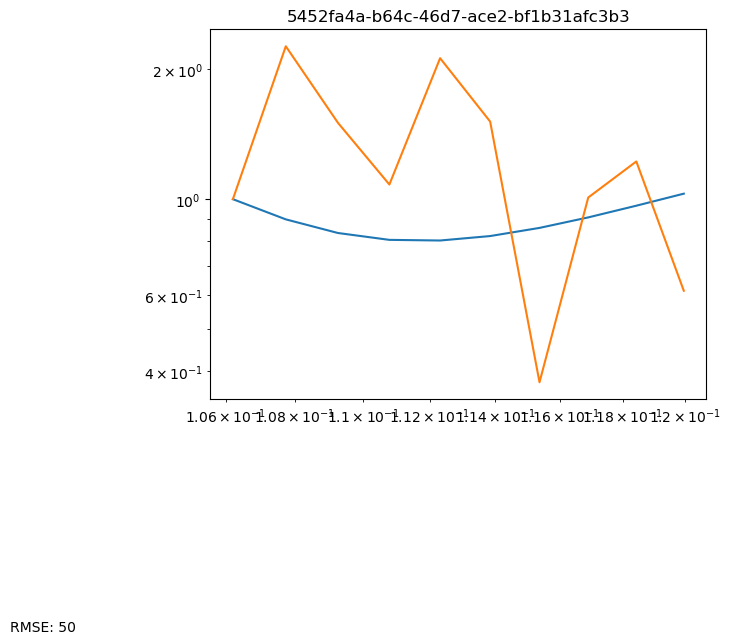

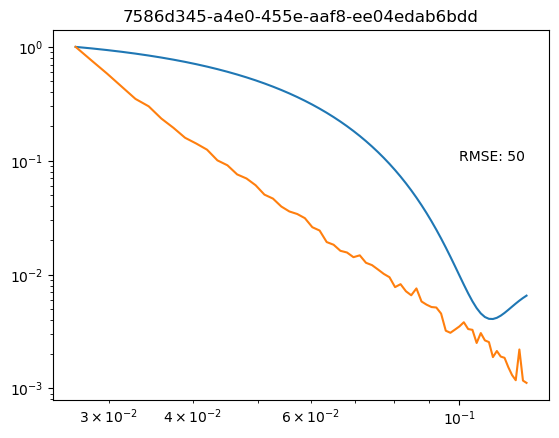

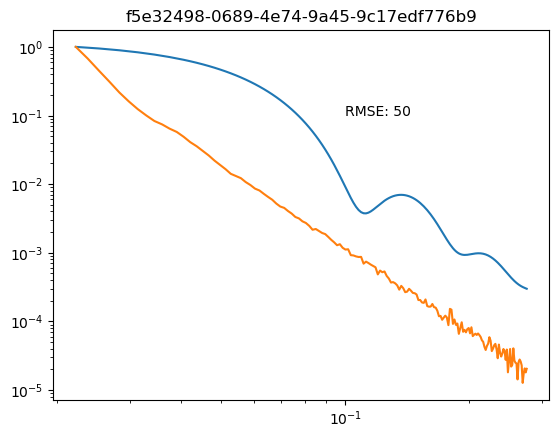

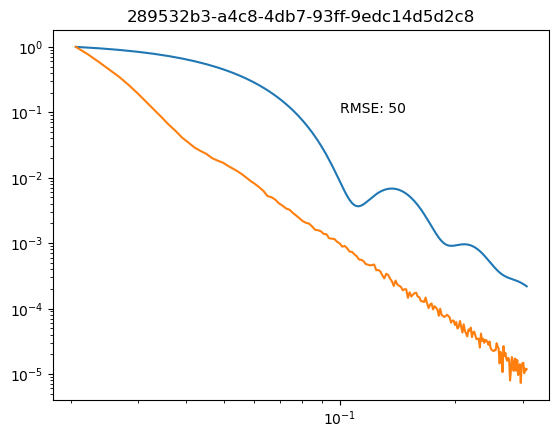

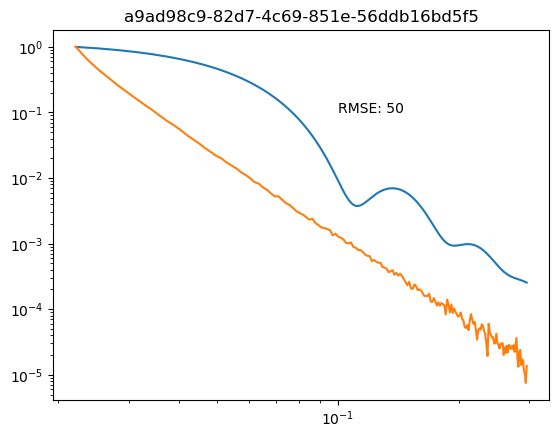

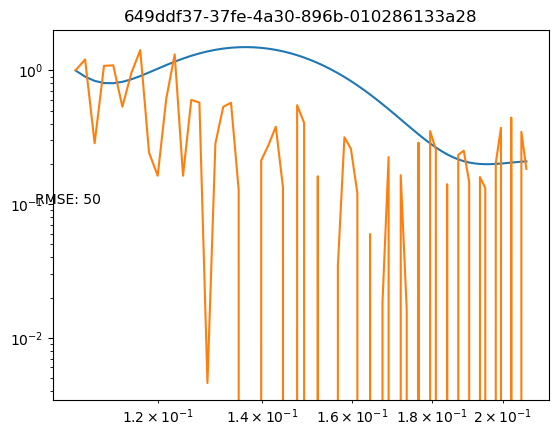

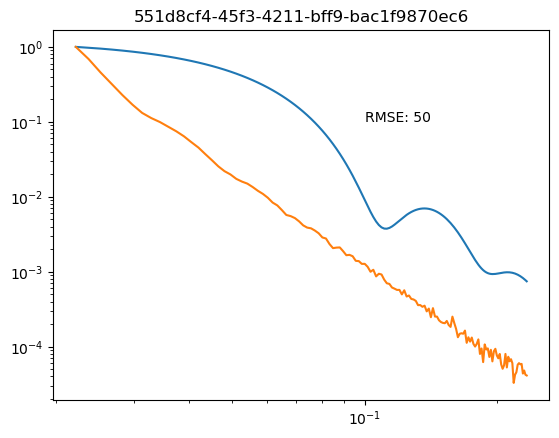

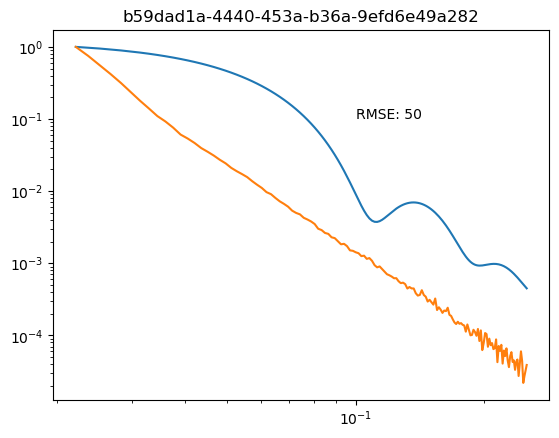

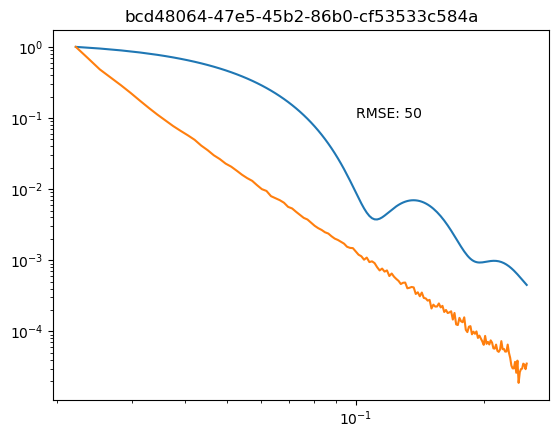

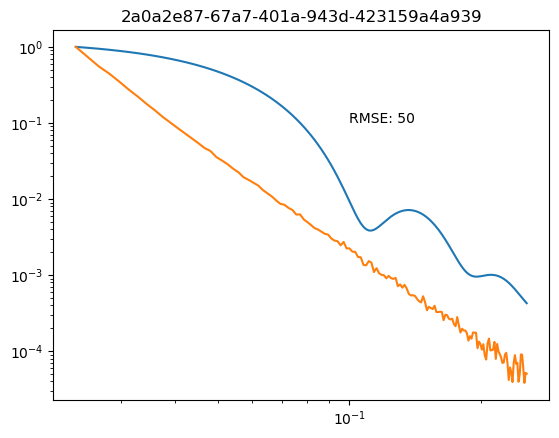

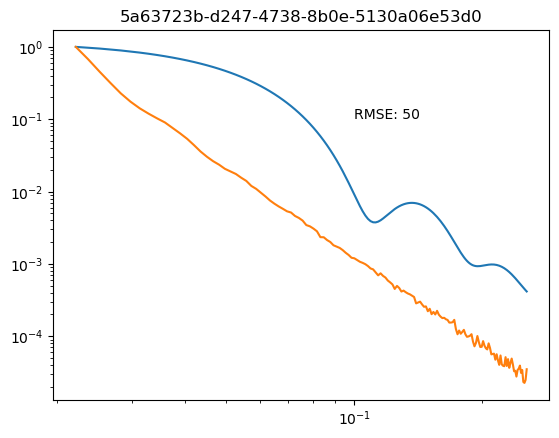

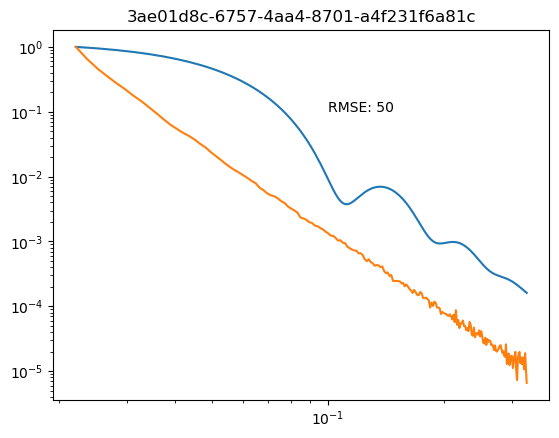

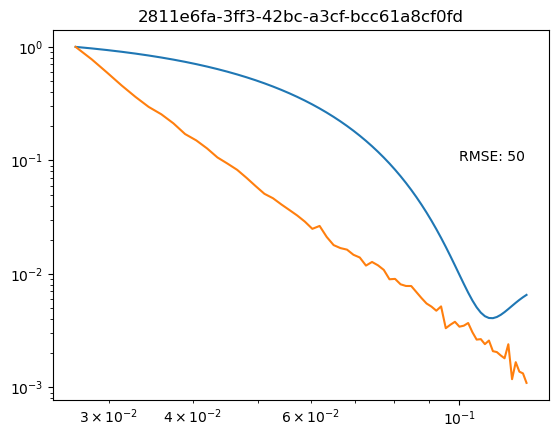

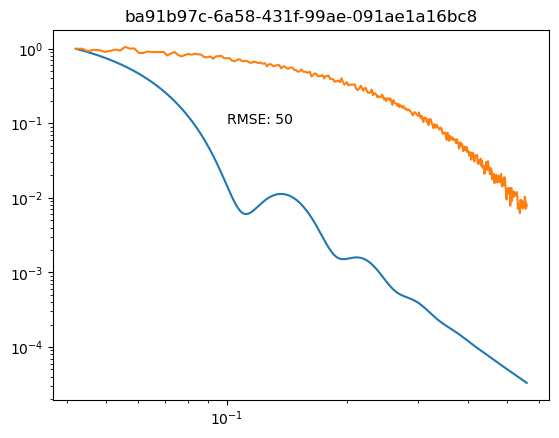

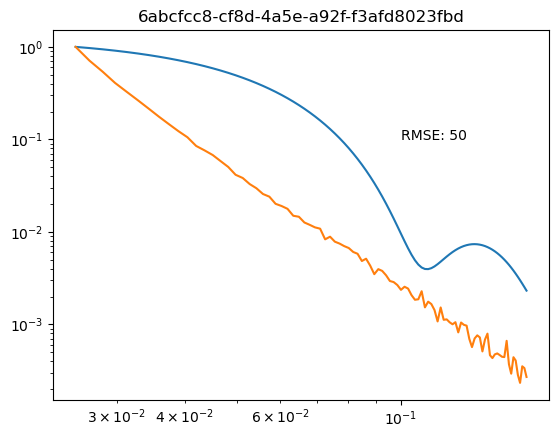

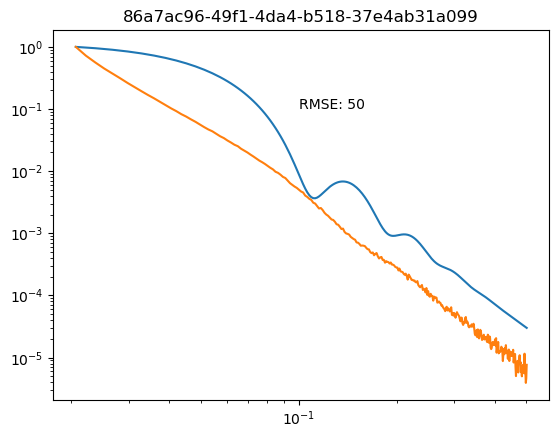

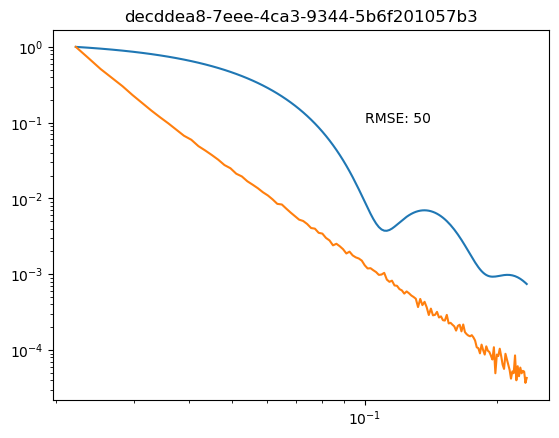

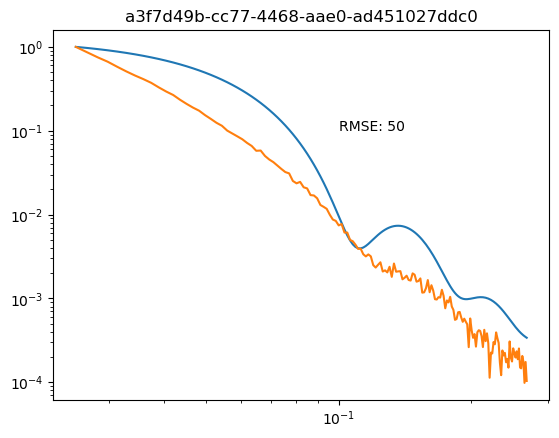

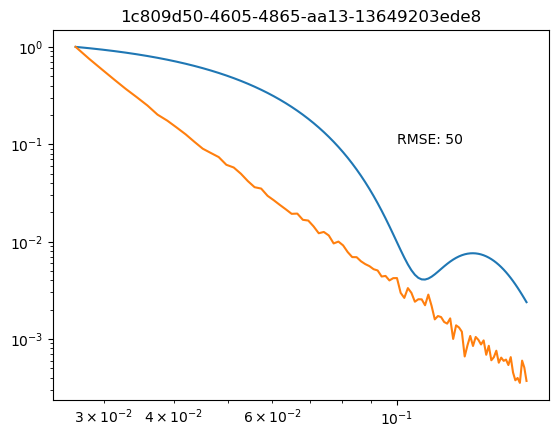

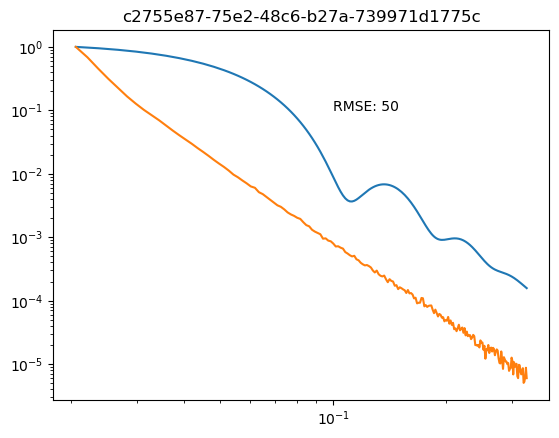

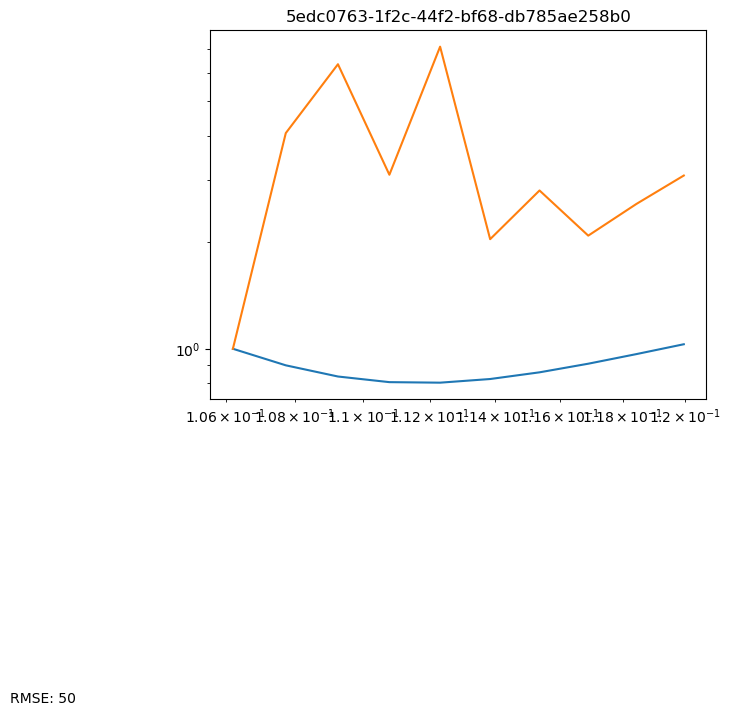

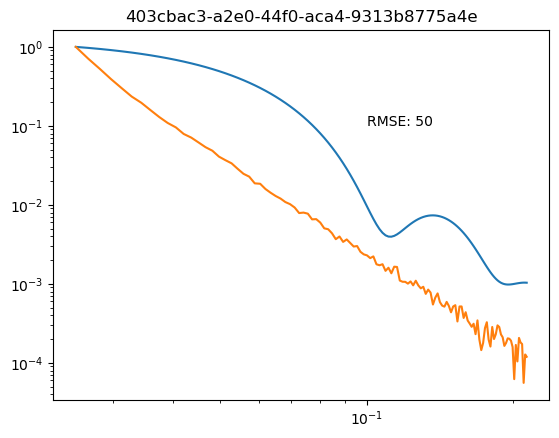

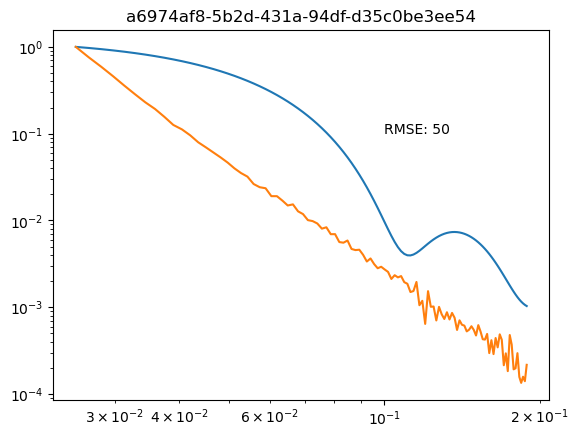

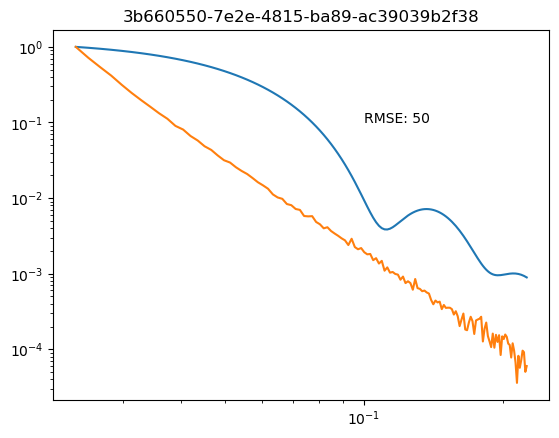

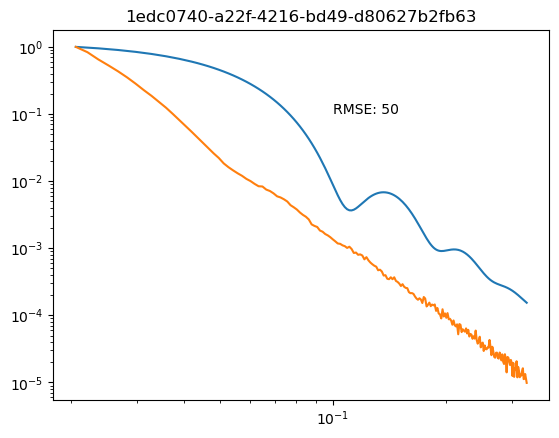

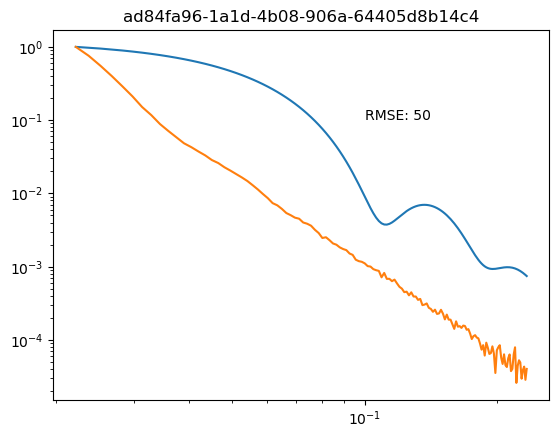

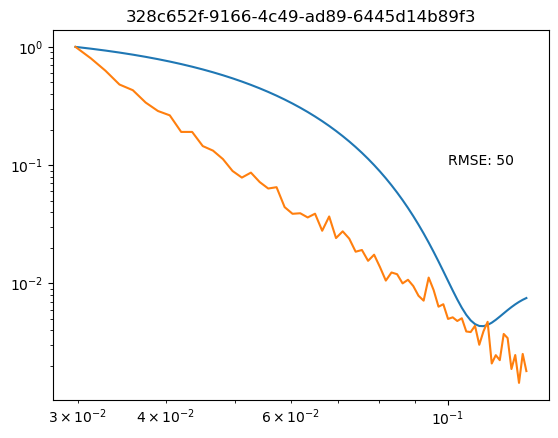

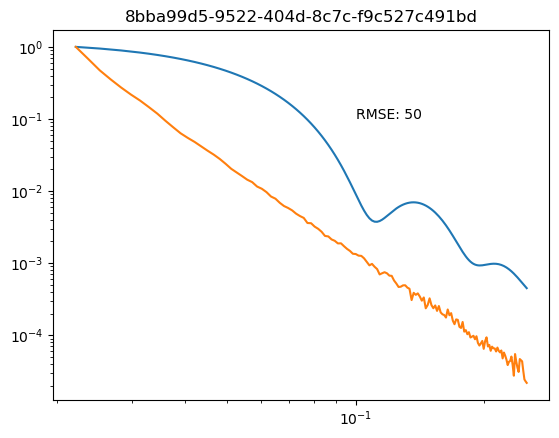

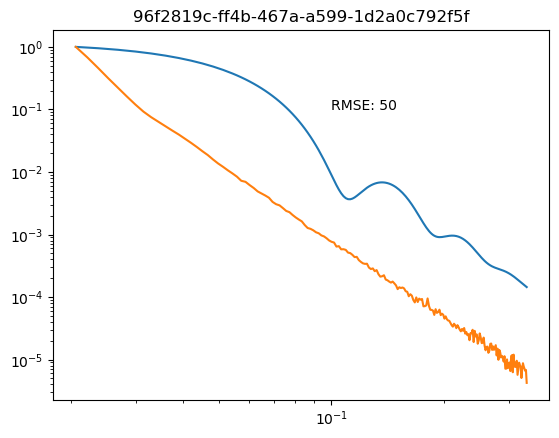

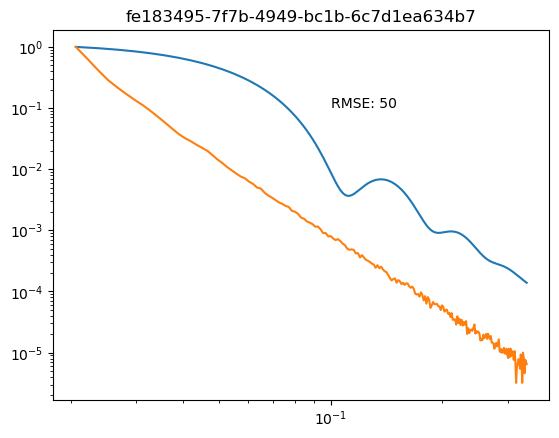

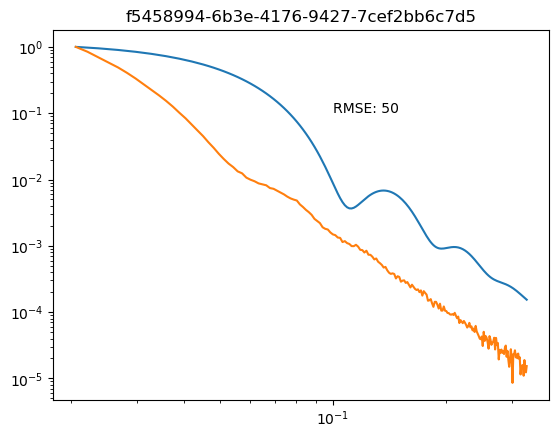

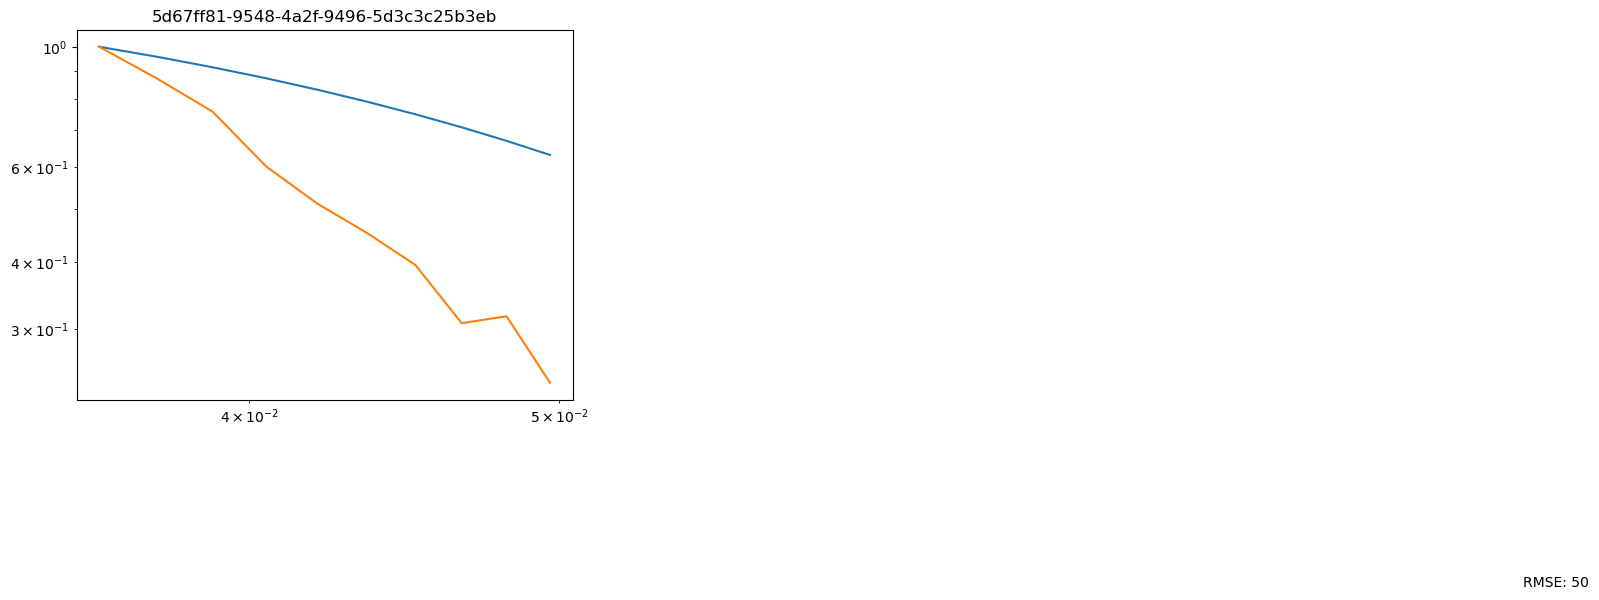

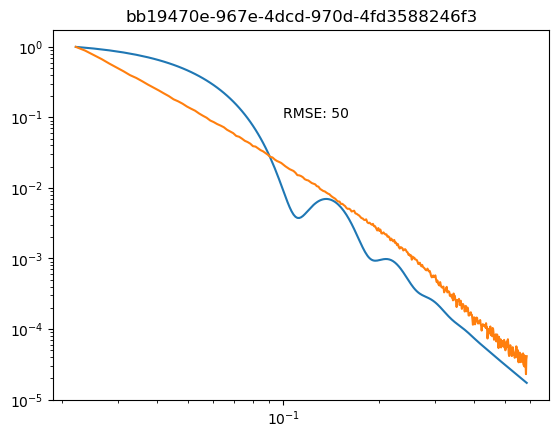

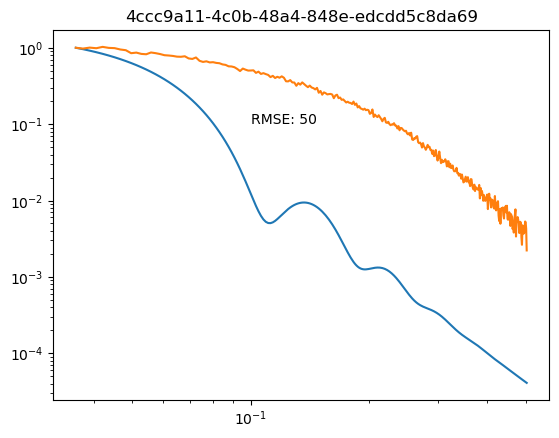

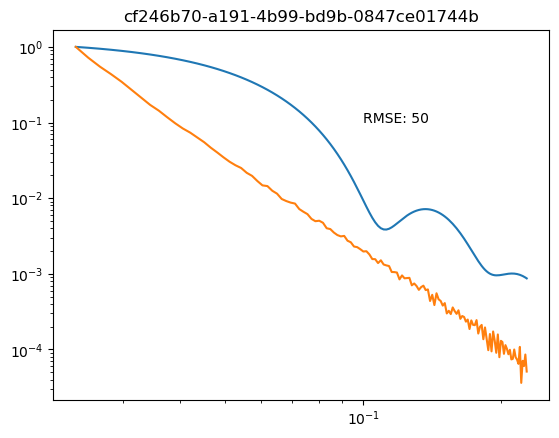

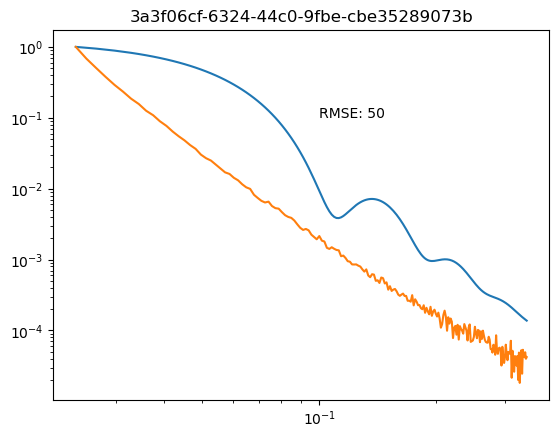

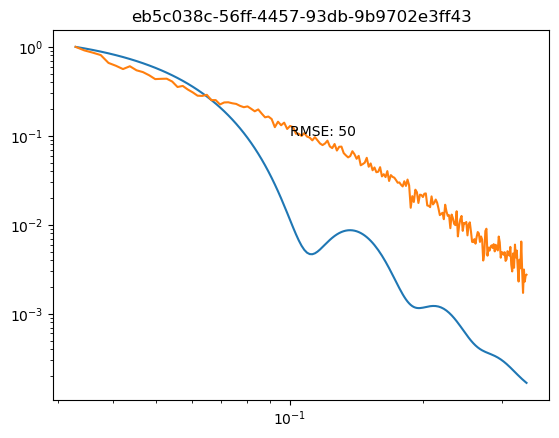

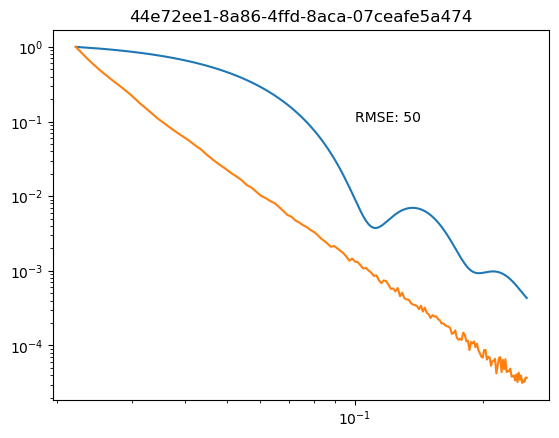

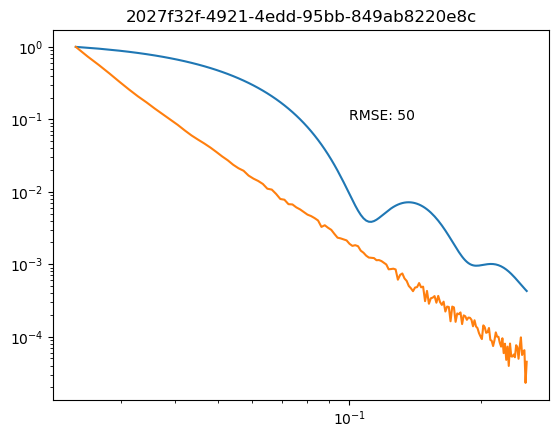

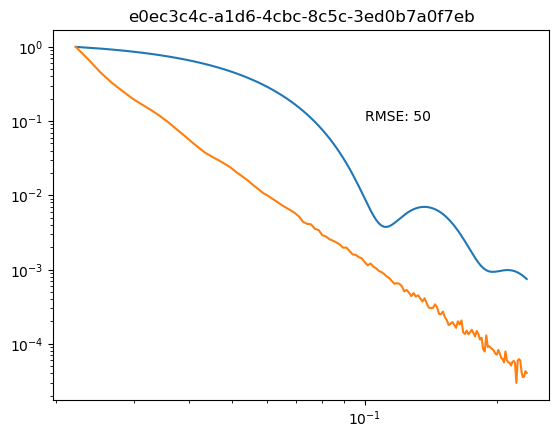

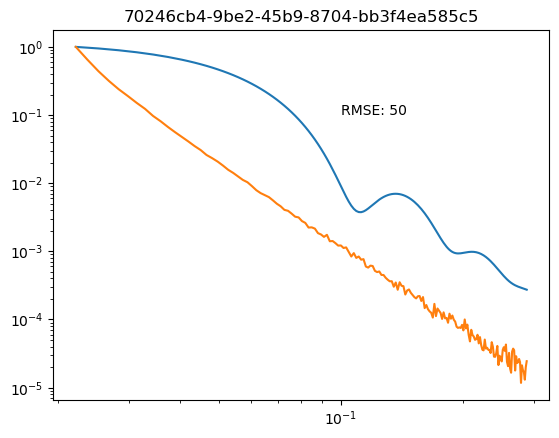

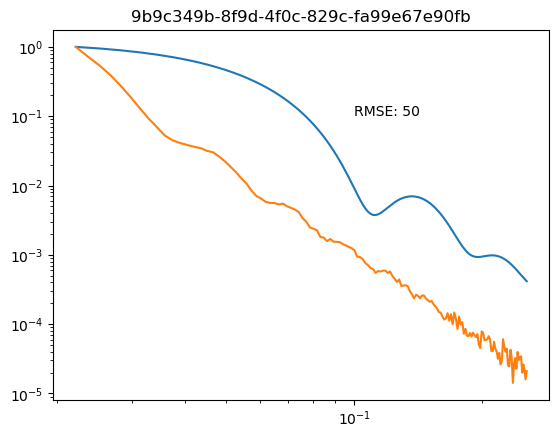

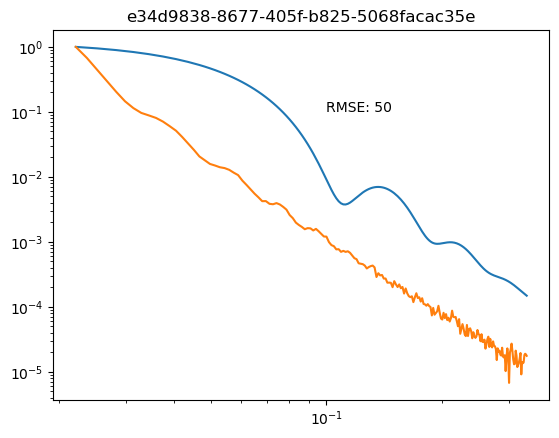

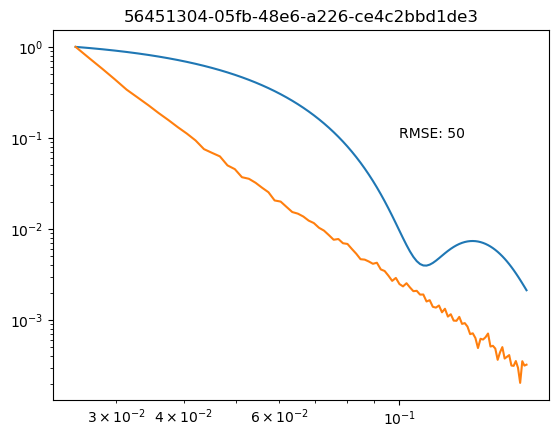

In [151]:
for uuid_val in uuid_sorted:
    data_val = data[uuid_val][0]
    q = data_val['q'].to_numpy()
    target_I = target_intensities(q, target_r, target_pdi)

    target_I = target_I/target_I[0]
    meas_I = data_val['I']/data_val['I'].iloc[0]

    rmse = distance_results[uuid_val]
    fig, ax = plt.subplots()

    ax.loglog(q, target_I)
    ax.loglog(q, meas_I)
    ax.text(0.1, 0.1, f'RMSE: {rmse}')
    ax.set_title(uuid_val)

In [153]:
synth_table = pandas.read_csv('synth_table_master_10_28_24.csv')

In [157]:
synth_table = synth_table.set_index('uuid')

In [160]:
distance_metric_vals = []

for uuid_val in list(synth_table.index):
    try:
        dist = distance_results[uuid_val]
    except:
        dist = np.nan
    distance_metric_vals.append(dist)

In [162]:
synth_table['rmse_log_distance'] = distance_metric_vals

In [163]:
synth_table

teos_volume  ammonia_volume  \
uuid                                                                
4fd21940-a331-4524-b730-cf76de1b4d8d    50.000000      124.000000   
8933d4b1-8929-4b58-a491-a0c55df30fed    83.000000       58.000000   
130093e4-2947-4d37-b73a-ed4c23442ab8    20.000000       64.000000   
a3f7d49b-cc77-4468-aae0-ad451027ddc0   181.000000        9.000000   
f69628da-ff56-4f3a-ba2e-816036b87557   100.000000       52.000000   
...                                           ...             ...   
49908a7b-72dd-4050-aab5-05b2807f82f8    60.410553       94.258186   
5dca1867-c2bf-4e16-893b-57ec828b4951    94.733145      141.702552   
21ae2275-1852-4a8d-b2dc-6ec0b850491a    83.552676      104.173866   
d112b2bd-0447-459e-b875-15fb7e52b51f   113.713415       66.366096   
69bb4bea-49e0-4142-b3d6-7c4fbe1993f7    90.518169       94.714111   

                                      water_volume  ethanol_volume  \
uuid                                                                 
4fd21940-a331-4524-b730-cf76de1b4d8d    165.000000     1361.000000   
8933d4b1-8929-4b58-a491-a0c55df30fed    175.000000     1384.000000   
130093e4-2947-4d37-b73a-ed4c23442ab8     49.000000     1567.000000   
a3f7d49b-cc77-4468-aae0-ad451027ddc0    228.000000     1283.000000   
f69628da-ff56-4f3a-ba2e-816036b87557     15.000000     1534.000000   
...                                            ...             ...   
49908a7b-72dd-4050-aab5-05b2807f82f8     21.613657     1523.717603   
5dca1867-c2bf-4e16-893b-57ec828b4951     95.777438     1367.786865   
21ae2275-1852-4a8d-b2dc-6ec0b850491a     91.429381     1420.844077   
d112b2bd-0447-459e-b875-15fb7e52b51f    222.160905     1297.759584   
69bb4bea-49e0-4142-b3d6-7c4fbe1993f7    192.961617     1321.806103   

                                      dilution_volume_fraction  \
uuid                                                             
4fd21940-a331-4524-b730-cf76de1b4d8d                  0.362682   
8933d4b1-8929-4b58-a491-a0c55df30fed                  0.218193   
130093e4-2947-4d37-b73a-ed4c23442ab8                  0.903794   
a3f7d49b-cc77-4468-aae0-ad451027ddc0                  0.100743   
f69628da-ff56-4f3a-ba2e-816036b87557                  0.182971   
...                                                        ...   
49908a7b-72dd-4050-aab5-05b2807f82f8                  0.452263   
5dca1867-c2bf-4e16-893b-57ec828b4951                  0.288404   
21ae2275-1852-4a8d-b2dc-6ec0b850491a                  0.326996   
d112b2bd-0447-459e-b875-15fb7e52b51f                  0.240266   
69bb4bea-49e0-4142-b3d6-7c4fbe1993f7                  0.301834   

                                      silica_mass_conc  silica_mass_fraction  \
uuid                                                                           
4fd21940-a331-4524-b730-cf76de1b4d8d          7.951422              0.009674   
8933d4b1-8929-4b58-a491-a0c55df30fed         13.216927              0.016085   
130093e4-2947-4d37-b73a-ed4c23442ab8          3.190814              0.003982   
a3f7d49b-cc77-4468-aae0-ad451027ddc0         28.625618              0.034357   
f69628da-ff56-4f3a-ba2e-816036b87557         15.761151              0.019630   
...                                                ...                   ...   
49908a7b-72dd-4050-aab5-05b2807f82f8          9.564710              0.011908   
5dca1867-c2bf-4e16-893b-57ec828b4951         14.998954              0.018328   
21ae2275-1852-4a8d-b2dc-6ec0b850491a         13.228767              0.016243   
d112b2bd-0447-459e-b875-15fb7e52b51f         18.004071              0.021676   
69bb4bea-49e0-4142-b3d6-7c4fbe1993f7         14.331603              0.017332   

                                      ethanol_dilute_vol  sample_dilute_vol  \
uuid                                                                          
4fd21940-a331-4524-b730-cf76de1b4d8d                 NaN                NaN   
8933d4b1-8929-4b58-a491-a0c55df30fed                 NaN                NaN   
130093e4-2947

In [164]:
synth_table.to_csv('synth_table_with_rmsedist_10_28_24.csv')

(0.0, 3.0)

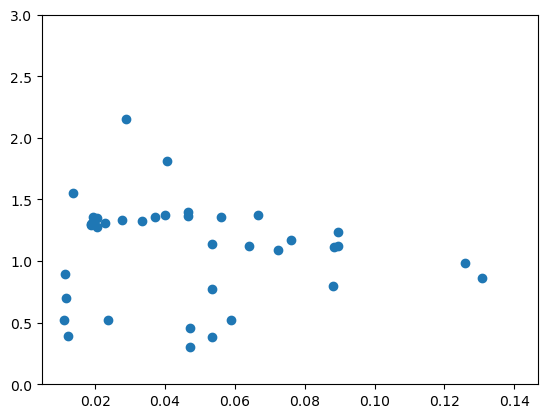

In [167]:
plt.scatter(synth_table['teos_vol_frac'], synth_table['rmse_log_distance'])
plt.ylim(0, 3)